# Total Energy Prediction - Neural Network

## Introduction

In this notebook we will machine-learn the relationship between a molecular descriptor and total energy using neural networks.

The energy of ~134k molecules was calculated at the CCSD level.

## Setup

In [21]:
# --- INITIAL DEFINITIONS ---
from sklearn.neural_network import MLPRegressor
import numpy, math, random
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from mpl_toolkits.mplot3d import Axes3D

Let's pick a descriptor. Allowed types are:

1. cnt: atom counts
2. bob: bag of bonds
4. soap: smooth overlap of atomic positions; choose from:
    1. soap.sum - all atoms summed together
    4. soap.mean - mean of all atom SOAP
    4. soap.centre - computed at the central point
5. mbtr: many-body tensor representation
6. cm: Coulomb matrix

In [26]:
# TYPE is the descriptor type  you can change it
TYPE = "bob"

#show descriptor details
print("\nDescriptor details")
desc = open("./data/descriptor."+TYPE.split('.')[0]+".txt","r").readlines()
for l in desc: print(l.strip())
print(" ")


Descriptor details
Bag of Bonds

Each molecule is described by 15+5 integer numbers. The first 15 are the bound counts for each pair-type.
The last 5 are the neighbour count of each type [H,C,N,O,F].
 


and load the databases with the descriptors (input) and the correct charge densities (output). Databases are quite big, so we can decide how many samples to use for training.

In [68]:
# load input/output data
trainIn = load_npz("./data/energy.input."+TYPE+".npz").toarray()
trainOut = numpy.load("./data/energy.output.npy")
trainIn = trainIn.astype(dtype=numpy.float64, casting='safe')


import numpy as np
def zscore(X): # z-score uses to normalise the data. Hommeeeewoooorrrkk
    
    # get the shape of the data matrix
    [nX,mX] = X.shape
    
    # compute the mean of every column X
    XMean = np.mean(X, axis=0)
    
    # compute standard deviation of each column
    XStd = np.std(X,axis=0,ddof=1)
    
    # subtract the mean from each column
    zX = X - np.kron(np.ones((nX,1)),XMean) # Z = [X - mX]
    
    # divide by the stdv
    XStd [XStd ==0] = 1
    Zscore = np.divide(zX,XStd)
    
    
    return Zscore

trainIn= zscore(trainIn)



def PCA(X):
    
    # computes the covariance of X   Hommeeeewoooorrrkk
    # numpy covariance function assumes different ordering, so we transpose X
    XCov = np.cov(X.T)
    
    # solves the eigenproblem and stores eigvals (give the variance) in D and eigvecs in V
    D, V = np.linalg.eig(XCov)
    
    # perform the linear transformation - matrix-matrix multiplication
    Yn = np.dot(X,V)

    # return the eigenvector matrix V, the transformed data Yn, and the eigenvalues D
    return V,Yn,D


V, X, D= PCA(trainIn)
print(X.shape)
trainIn= X[:,0:10]

# decide how many samples to take from the database
samples  = min(trainIn.shape[0], 9000)
vsamples = min(trainIn.shape[0]-samples,1000)
print("training samples:   "+str(samples))
print("validation samples: "+str(vsamples))
print("number of features: {}".format(trainIn.shape[1]))

# split between training and validation
validIn = trainIn[samples:samples+vsamples]
validOut = trainOut[samples:samples+vsamples]

trainIn  = trainIn[0:samples]
trainOut = trainOut[0:samples]

# shift and scale the inputs
train_mean = numpy.mean(trainIn, axis=0)
train_std = numpy.std(trainIn, axis=0)
train_std[train_std==0] = 1
for a in range(trainIn.shape[1]):
    trainIn[:,a] -= train_mean[a]

for a in range(trainIn.shape[1]):
    trainIn[:,a] /= train_std[a]
# also for validation set
for a in range(validIn.shape[1]):
    validIn[:,a] -= train_mean[a]
for a in range(validIn.shape[1]):
    validIn[:,a] /= train_std[a]
    

# show the first few descriptors
print("\nDescriptors for the first 5 molecules:")
print(trainIn[0:5])


(133885, 20)
training samples:   9000
validation samples: 1000
number of features: 10

Descriptors for the first 5 molecules:
[[-1.26902114e-01  1.56879309e+00  7.64194985e-01  1.62281431e-01
   1.15478810e-02  8.56481274e-02 -6.14817054e-01  6.79731938e-01
  -5.46860343e-01 -1.00305033e-01]
 [ 9.80184269e-01  1.86476201e+00  4.45311088e-01  1.24957546e-02
   4.75056837e-02  7.35365965e-01  1.38458648e+00  8.73574575e-01
   1.13871947e+00  1.32874677e+00]
 [ 2.76639808e+00  3.50886973e+00 -1.40233279e+01 -1.95956587e-01
   4.57037552e+00 -2.66229056e+00 -3.71314240e+00  2.17771459e+00
  -1.50127228e-02 -7.07179672e-01]
 [ 1.73482504e-01  4.23390600e-01  1.72673140e-01 -5.92315685e-01
  -7.11117559e-01  1.21930887e+00 -1.30615222e+00 -7.23105108e-01
  -3.45255210e-01  4.45277322e-01]
 [ 3.00973651e-01 -2.52701653e-01  4.29476471e-01 -2.20362482e-02
   1.11492786e+00 -9.72390519e-01 -2.80428314e-01 -1.61092533e+00
  -6.16005608e-02 -1.01473627e+00]]


Next we setup a multilayer perceptron of suitable size. Out package of choice is scikit-learn, but more efficient ones are available.<br>
Check the scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html">documentation</a> for a list of parameters.

In [65]:
# setup the neural network
nn = MLPRegressor(hidden_layer_sizes=(40,20,5),  activation='relu', solver='lbfgs', alpha=0.01, 
                  learning_rate='adaptive')

## Training
Now comes the tough part! The idea of training is to evaluate the ANN with the training inputs and measure its error (since we know the correct outputs). It is then possible to compute the derivative (gradient) of the error w.r.t. each parameter (connections and biases). By shifting the parameters in the opposite direction of the gradient, we obtain a better set of parameters, that should give smaller error.
This procedure can be repeated until the error is minimised.


It may take a while...

In [66]:
# use this to change some parameters during training if the NN gets stuck in a bad spot
nn.set_params(solver='lbfgs')

nn.fit(trainIn, trainOut);

Check the ANN quality with a regression plot, showing the mismatch between the exact and NN predicted outputs for the validation set.

Mean Abs Error (training)  :  11.39524432241515
Mean Abs Error (validation):  11.794137907230112


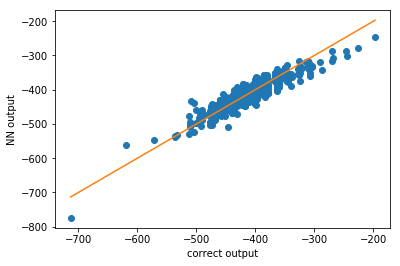

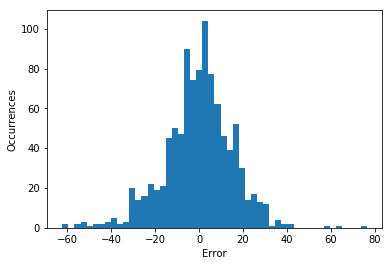

In [67]:
# evaluate the training and validation error
trainMLOut = nn.predict(trainIn)
validMLOut = nn.predict(validIn)

print ("Mean Abs Error (training)  : ", (numpy.abs(trainMLOut-trainOut)).mean())
print ("Mean Abs Error (validation): ", (numpy.abs(validMLOut-validOut)).mean())

plt.plot(validOut,validMLOut,'o')
plt.plot([min(validOut),max(validOut)],[min(validOut),max(validOut)]) # perfect fit line
plt.xlabel('correct output')
plt.ylabel('NN output')
plt.show()

# error histogram
plt.hist(validMLOut-validOut,50)
plt.xlabel("Error")
plt.ylabel("Occurrences")
plt.show()

# Exercises

### 1. Compare descriptors
Keeping the size of the NN constant, test the accuracy of different descriptors with the same NN size, and find the best one for these systems.

In [ ]:
# DIY code here...

### 2. Combine with Principal Component Analysis - Advanced
Reduce the descriptor size with PCA (check the PCA.ipynb notebook) and train again. Can you get similar accuracy with much smaller networks?